# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 4 minutes

This notebooks demonstrates an algorithm that analyzes the concordance of the results of an experiment to the graph.

### Notebook Imports

In [1]:
import logging
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from matplotlib_venn import venn2
import seaborn as sns

import pybel
import pybel_tools as pbt
from pybel_tools.analysis.concordance import *
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
from pybel_tools.visualization import to_jupyter

In [2]:
#%config InlineBackend.figure_format = 'svg'
#%matplotlib inline

### Notebook Provenance

The time of execution, random number generator seed, and the versions of the software packages used are displayed explicitly.

In [3]:
time.asctime()

'Sat Aug 12 19:15:05 2017'

In [4]:
# seed the random number generator
import random
random.seed(127)

In [5]:
pybel.__version__

'0.7.3-dev'

In [6]:
pbt.__version__

'0.1.18-dev'

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [7]:
bms_base = os.environ['BMS_BASE']

#### OwnCloud

The differential gene expression data used in this notebook is currently not published, and is obfuscated with reference through our team's internal data storage system with [OwnCloud](https://owncloud.org/).

In [8]:
owncloud_base = os.environ['OWNCLOUD_BASE']

# Data

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [9]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers', 'alzheimers.gpickle')

In [10]:
graph = pybel.from_pickle(pickle_path)

In [11]:
graph.version

'3.0.9'

All orthologies are discared before analysis.

In [12]:
pbt.filters.remove_nodes_by_namespace(graph, 'MGI')
pbt.filters.remove_nodes_by_namespace(graph, 'RGD')

To merge the differential gene expression annotations, the entire graph is collapsed to genes using [pbt.mutation.collapse_by_central_dogma_to_genes](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.collapse_by_central_dogma_to_genes)

In [13]:
pbt.mutation.collapse_by_central_dogma_to_genes(graph)

pbt.mutation.rewire_variants_to_genes(graph)

In [14]:
pbt.summary.print_summary(graph)

Nodes: 3659
Edges: 20012
Citations: 1753
Authors: 9280
Network density: 0.0014951486863058218
Components: 71
Average degree: 5.4692538945066955
Compilation warnings: 2493


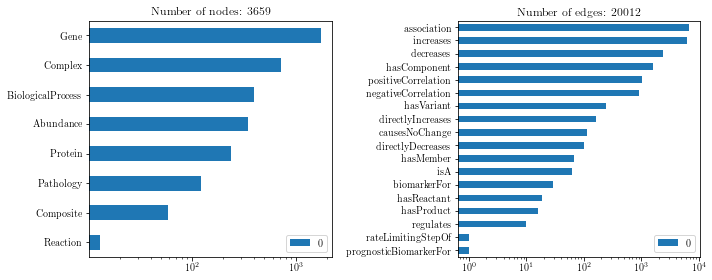

In [15]:
pbt.summary.plot_summary(graph, plt, figsize=(10, 4))
plt.show()

## Differential Gene Expression

Differential gene expression data can be obtained from many sources, including ADNI and other large clinical studies. This analysis is concerned with the log-fold-changes on each gene, and not necessarily the p-value. This is better as a data-driven process becuase it does not require a model or multiple hypothesis testing on raw data.

In [16]:
data_path = os.path.join(owncloud_base, 'alzheimers', 'SevAD.csv')
target_columns = ['Gene.symbol', 'logFC']

In [17]:
df = pd.read_csv(data_path)
df = df.loc[df['Gene.symbol'].notnull(), target_columns]
df.head()

,Gene.symbol,logFC
0,ZNF616,-4.244691
1,DEFB125,3.974393
3,SNAP23,3.337636
4,PHLDB2,3.192559
5,LOC389895,-4.296850


A histogram of the log-fold-changes shows that the data are normally distributed, as expected for differential gene expression data.

In [18]:
# max_fc = {}
# for row, symbol, fc in df.itertuples():
#    if symbol not in max_fc or abs(max_fc[symbol]) < abs(fc):
#        max_fc[symbol] = fc
        
data = {k: v for _, k, v in df.itertuples()}

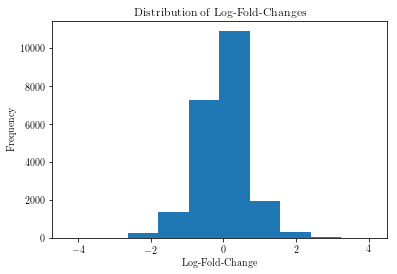

In [19]:
plt.title('Distribution of Log-Fold-Changes')
plt.xlabel('Log-Fold-Change')
plt.ylabel('Frequency')
plt.hist(list(data.values()))
plt.show()

## Overlap Summary

The number of shared elements in the knowledge assembly and differential gene data set are counted.

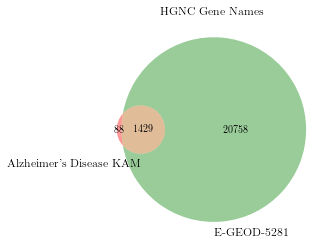

In [20]:
hgnc_names = pbt.summary.get_names_by_namespace(graph, 'HGNC')
df_names = set(df['Gene.symbol'])
overlapping_hgnc_names = hgnc_names & df_names

plt.title('HGNC Gene Names')
venn2([hgnc_names, df_names], set_labels=["Alzheimer's Disease KAM", 'E-GEOD-5281'])
plt.show()

# Analysis

## Data Integration

Finally, the differential gene expression data are ovelayed on the BEL graph with [pbt.integration.overlay_type_data](http://pybel-tools.readthedocs.io/en/latest/integration.html#pybel_tools.integration.overlay_type_data)

In [21]:
key = 'weight'
cutoff = 0.3

In [22]:
pbt.integration.overlay_type_data(graph, data, key, GENE, 'HGNC', overwrite=False, impute=0)

In [23]:
graph.edge[graph.nodes()[25]].keys()

dict_keys([('Pathology', 'MESHD', 'Alzheimer Disease'), ('Gene', 'dbSNP', 'rs12129547')])

## Concordance

The concordance is calculated over the full network

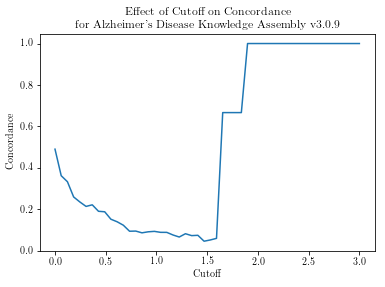

In [24]:
cutoffs = np.linspace(0, 3, 50)

plt.plot(cutoffs, [
    calculate_concordance(graph, key, cutoff=c)
    for c in cutoffs
])

plt.title('Effect of Cutoff on Concordance \nfor {}'.format(graph))
plt.ylabel('Concordance')
plt.xlabel('Cutoff')
plt.show()

### Stratify by Subgraph

The distribution of the concordance values across the stratified subgraphs is displayed below.

In [25]:
%%time
results = calculate_concordance_by_annotation(graph, 'Subgraph', key, cutoff)

CPU times: user 367 ms, sys: 26.9 ms, total: 394 ms
Wall time: 394 ms


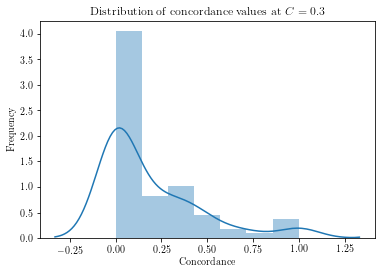

In [26]:
sns.distplot(
    [
        x
        for x in results.values() 
        if x != -1
    ],
)

plt.title('Distribution of concordance values at $C={}$'.format(cutoff))
plt.xlabel('Concordance')
plt.ylabel('Frequency')
plt.show()

In [27]:
concordance_df = pd.DataFrame.from_dict(
    {
        value.replace(' subgraph', ''): calculate_concordance_helper(subgraph, key, cutoff)
        for value, subgraph in pbt.selection.get_subgraphs_by_annotation(graph, 'Subgraph').items()
    }, 
    orient='index'
)

The non-null values are output below.

In [28]:
{
    k: v 
    for k, v in results.items() 
    if v != -1.0
}

{'ADAM Metallopeptidase subgraph': 0.0,
 'APOE subgraph': 0.0,
 'Acetylcholine signaling subgraph': 0.5,
 'Akt subgraph': 0.2857142857142857,
 'Albumin subgraph': 0.75,
 'Amyloidogenic subgraph': 0.1,
 'Apoptosis signaling subgraph': 0.2,
 'Autophagy signaling subgraph': 0.0,
 'Axonal transport subgraph': 0.3333333333333333,
 'Bcl-2 subgraph': 0.21428571428571427,
 'Beta secretase subgraph': 0.0,
 'Binding and Uptake of Ligands by Scavenger Receptors': 0.4,
 'Calcium-dependent signal transduction': 0.0,
 'Calsyntenin subgraph': 0.0,
 'Caspase subgraph': 0.21739130434782608,
 'Cell adhesion subgraph': 0.0,
 'Cell cycle subgraph': 1.0,
 'Chaperone subgraph': 0.18181818181818182,
 'Chemokine signaling subgraph': 0.3333333333333333,
 'Cholesterol metabolism subgraph': 0.0,
 'Complement system subgraph': 0.5,
 'Cyclin-CDK subgraph': 0.0,
 'Cytokine signaling subgraph': 0.0,
 'DKK1 subgraph': 0.5,
 'Electron transport chain': 0.0,
 'Endosomal lysosomal subgraph': 0.1111111111111111,
 'G-prot

## Conclusions

Varying the threshold from just zero to just above zero to much more stringent reveals varying results. High-dimensional data visualization techniques will need to be used to identify the effect of the threshold, and eventually the stability of concordance values through randomized permutation tests to assess the reliability of this method.